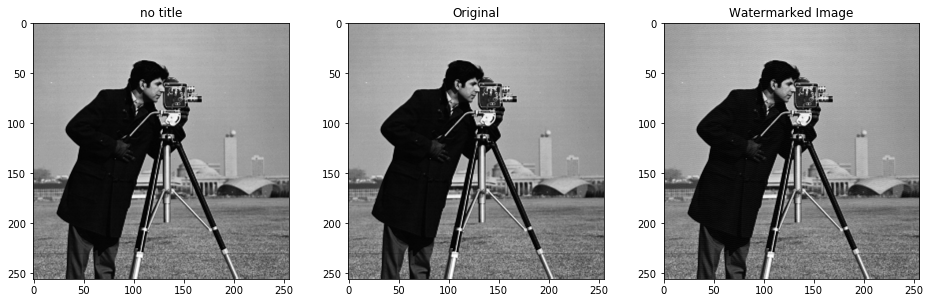

In [76]:
import skimage
%matplotlib inline
from skimage import io
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.figure(1,figsize=(16,16))
number = 0
def next_item_to_figure(data, type_of_data='img', title='no title'):
    global number 
    number += 1
    lines = 3
    columns = 3
    plt.subplot(lines*100+columns*10+number)
    plt.title(title)
    if type_of_data == 'img':
        plt.imshow(data,'gray')
    if type_of_data == 'fft':
        plt.imshow(np.log(1+np.abs(data)),'gray')
    if type_of_data == 'hist':
        vals, bins = np.histogram(data,bins=256)
        plt.plot(bins[:-1],vals)
    if type_of_data == 'vals':
        plt.plot(data[0],data[1])
    if type_of_data == 'val':
        plt.plot(data)
        
import pywt
from skimage import data, img_as_float
from skimage.transform import resize
img = data.camera() # cameraman image
img = img_as_float(img)
img = resize(img, (256,256), mode='reflect')

# Punkt 3
def generate_watermark_sequence(N, watermark_string):
    import hashlib
    hash_val = hashlib.md5(watermark_string).hexdigest()
    bin_val = list(bin(int(hash_val, 16))[2:])
    for i in range(0,len(bin_val)):
        if bin_val[i] == '0':
            bin_val[i] = -1
        else:
            bin_val[i] = 1
    while(len(bin_val)<N):
        bin_val = bin_val + bin_val
    return bin_val

def embed(img, where, alpha, seed):
    wc = pywt.wavedec2(img, 'db1', level=where['level'])
    #next_item_to_figure(wc[0], title='wc[0], level 2')
    # Punkt 2
    level1_wc = list(wc[where['depth']])
    #next_item_to_figure(wc[where['depth']][where['subband']], title='wc[2][0]')
    signal = level1_wc[where['subband']]
    signal_vec = signal.ravel()
    watermark_sequence = generate_watermark_sequence(len(signal_vec), seed)
    
    # Punkt 4 : Add the sequence to the wavelet coefficients of the subband
    #next_item_to_figure(signal_vec,'hist', title='Histogram wc[2][0]')
    #new_signal = signal_vec + alpha*watermark
    signal_vec = np.array([signal_vec[i]+alpha*watermark_sequence[i] for i in range(0,len(signal_vec))])
    #signal_vec[np.abs(signal_vec)<0.2]=0 # here insted add your watermark
    #next_item_to_figure(signal_vec,'hist', title='Watermark added')

    level1_wc[where['subband']] = signal_vec.reshape(level1_wc[where['subband']].shape)
    wc[where['depth']] = level1_wc
    #next_item_to_figure(wc[2][0], title='Wavelets modified')

    watermarked_image = pywt.waverec2(wc, 'db1')
    
    return watermarked_image, watermark_sequence

hidden_place = {'level':2, 'depth':2, 'subband':0}
password = "Gruppe2 - Image"
alpha = 0.01 # 0 <= alpha <= 1

#print wc
# print wc[0].shape # level x gesmoothed Bild
# print len(wc[1])
# print len(wc[2])
# next_item_to_figure(wc[1][0]) # horizontal parts
# next_item_to_figure(wc[1][1]) # vertical parts
# next_item_to_figure(wc[1][2]) # diagonal parts

# next_item_to_figure(wc[2][0]) # horizontal parts
# next_item_to_figure(wc[2][1]) # vertical parts
# next_item_to_figure(wc[2][2]) # diagonal parts

output, watermark_seq = embed(img=img, alpha=alpha, where=hidden_place, seed=password)

next_item_to_figure(img)
next_item_to_figure(img,title='Original')
next_item_to_figure(output, title='Watermarked Image')

true_watermark_score: 0.0101066918467


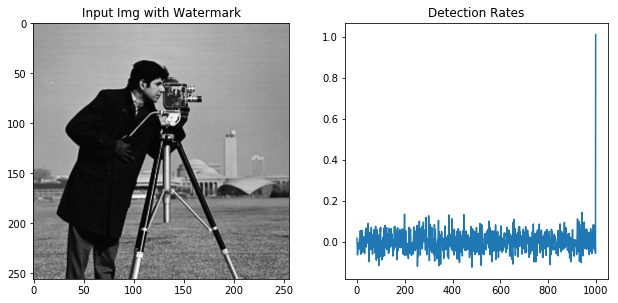

In [78]:
# Number 5.2
plt.figure(1,figsize=(16,16))
number = 0

def detect(img, where, w):
    wc = pywt.wavedec2(img, 'db1', level=where['level'])
    level1_wc = list(wc[where['depth']])
    #next_item_to_figure(wc[where['depth']][where['subband']], title='wc[2][0]')
    signal = level1_wc[where['subband']]
    signal_vec = signal.ravel()
    correlation = 1.0/len(signal_vec)
    corr_mul = [signal_vec[i]*w[i] for i in range(0,len(signal_vec))]
    corr_mul = sum(corr_mul)
    correlation = correlation*corr_mul
    return correlation
    
# 1/N * (x[0]*w[0] + ... + w[N]*x[N])
img = output
next_item_to_figure(img, title='Input Img with Watermark')

watermark_sequence = generate_watermark_sequence(len(signal_vec),"Gruppe2 - Image")
hidden_place = {'level':2, 'depth':2, 'subband':0}
true_watermark_score = detect(img, hidden_place, watermark_sequence)
print 'true_watermark_score: ' + str(true_watermark_score)



# Number 3

random_watermarks = [np.random.choice([-1,1], size=len(signal_vec), replace=True, p=None) for i in range(0,999)]

detection_rates = [detect(img, hidden_place, random_watermarks[i]) for i in range(0,999)]

detection_rates.append(true_watermark_score)
detection_rates = [i/alpha for i in detection_rates]
next_item_to_figure(detection_rates, type_of_data='val', title='Detection Rates')

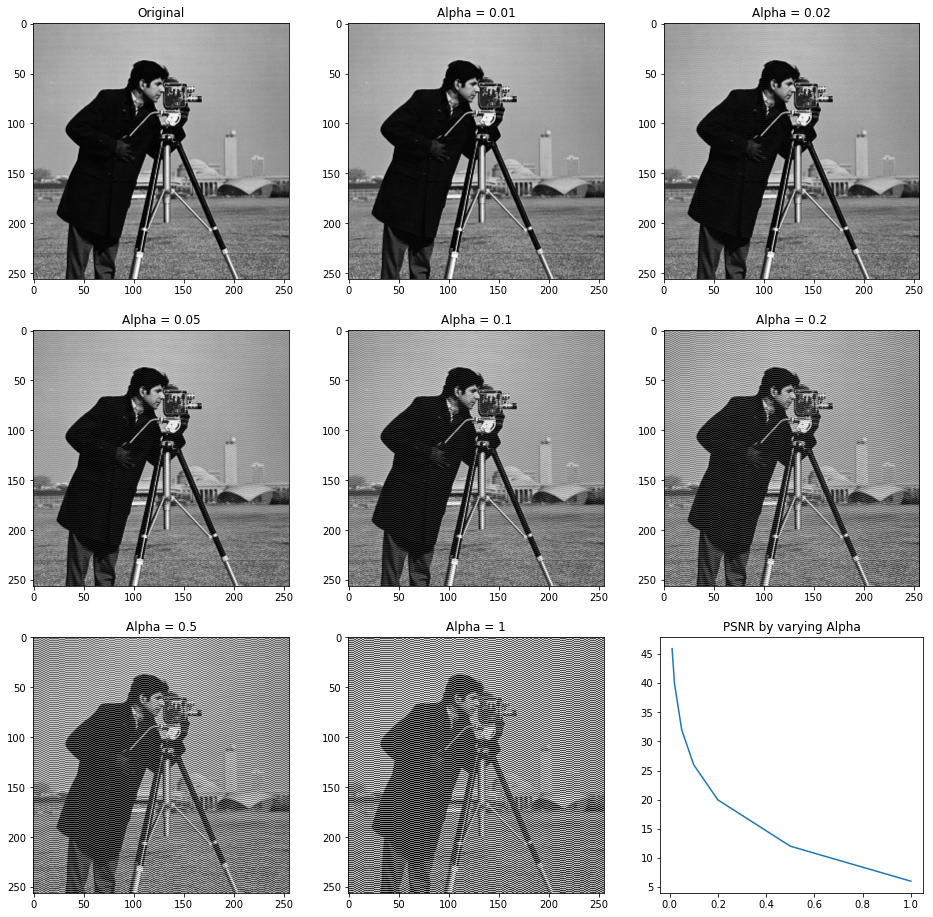

In [74]:
# Number 4
plt.figure(1,figsize=(16,16))
number = 0

def mean_squared_error(img1, img2):
    diff = img2-img1
    diff_squared = np.square(diff)
    all_vals = diff_squared.flatten()
    return sum(all_vals)/len(all_vals)

def psnr(img1, img2):
    import math
    img_psnr= 20*math.log(np.amax(img),10)-10*math.log(mean_squared_error(img1,img2),10) 
    #MAX possible pixel value = 255 (8 bit represenation)
    return img_psnr

alphas = [0.01,0.02,0.05,0.1,0.2,0.5,1]
psnrs = []
next_item_to_figure(img, title='Original')
for i in alphas:
    output, watermark_seq = embed(img=img, alpha=i, where=hidden_place, seed=password)
    next_item_to_figure(output, title='Alpha = '+ str(i))
    psnrs.append(psnr(img, output))
    
next_item_to_figure([alphas, psnrs],type_of_data='vals',title='PSNR by varying Alpha')